In [123]:
import numpy as np
import mne
from mne.datasets import sample
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import scipy.signal as sl
from typing import Optional
import scipy as sp
import sys
from nilearn import plotting
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.experimental.models import SPIRIT
from deepmeg.data.datasets import EpochsDataset, read_epochs_dataset
from torch.utils.data import DataLoader
from deepmeg.preprocessing.transforms import zscore
import torch
from collections import defaultdict
import torchmetrics
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg, PrintingCallback
from deepmeg.experimental.interpreters import SPIRITInterpreter
import random
import torch.nn as nn
from deepmeg.models.interpretable import BaseModel


def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

def accuracy(predictions, targets):

    # Convert one-hot encoded labels to class indices
    targets = torch.argmax(targets, dim=1)

    # Compute predicted class indices
    _, predicted = torch.max(predictions, dim=1)

    # Compute accuracy
    correct = torch.sum(predicted == targets)
    total = targets.shape[0]
    accuracy = correct / total

    return accuracy


In [ ]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
info = mne.io.read_raw_fif(fname_raw).resample(600).pick_types(meg='grad').info

In [124]:
dataset = read_epochs_dataset('../data/multimodal.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
x, y = next(iter(DataLoader(test, len(test))))
y.shape

torch.Size([282, 8])

In [3]:
class LFCNN_original(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        # self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.unmixing_layer = nn.Linear(n_channels, n_latent, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.max_pool = nn.MaxPool2d((1, pool_factor))
        self.relu = nn.ReLU()
        final_out_features = (n_times//pool_factor)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x.permute(0, -1, 1))
        x = self.temp_conv(x.permute(0, -1, 1))
        x = self.relu(x)
        x = self.max_pool(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 204, 301))

LFCNN_original(204, 301, 8, 50, 10, 8)(X)

/home/user/Projects/deepmeg/venv/lib/python3.11/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


tensor([[-0.2711,  0.2722,  0.0500, -0.1191, -0.2261, -0.0995, -0.0394,  0.2216]],
       grad_fn=<AddmmBackward0>)

In [4]:
kwargs = dict(
    n_channels=x.shape[1],
    n_times=x.shape[-1],
    filter_size=50,
    n_latent=8,
    pool_factor=10,
    n_outputs=y.shape[-1]
)

In [23]:
LFCNN_original(
    **kwargs
)(x).shape

torch.Size([282, 8])

In [9]:
from deepmeg.models.interpretable import LFCNN, BaseModel
# model = TSNet(**lfcnn_kwargs)

model = LFCNN_original(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
# loss = torch.nn.CrossEntropyLoss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [10]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.6920   |    accuracy_train:  0.1230   |    loss_val:  0.6227   |    accuracy_val:  0.1694
Epoch 1:  loss_train:  0.5913   |    accuracy_train:  0.1326   |    loss_val:  0.5332   |    accuracy_val:  0.2131
Epoch 2:  loss_train:  0.5075   |    accuracy_train:  0.1340   |    loss_val:  0.4640   |    accuracy_val:  0.1912
Epoch 3:  loss_train:  0.4477   |    accuracy_train:  0.1372   |    loss_val:  0.4252   |    accuracy_val:  0.1805
Epoch 4:  loss_train:  0.4200   |    accuracy_train:  0.1436   |    loss_val:  0.4184   |    accuracy_val:  0.1860
Epoch 5:  loss_train:  0.4193   |    accuracy_train:  0.1463   |    loss_val:  0.4263   |    accuracy_val:  0.1808
Epoch 6:  loss_train:  0.4248   |    accuracy_train:  0.1769   |    loss_val:  0.4283   |    accuracy_val:  0.2082
Epoch 7:  loss_train:  0.4216   |    accuracy_train:  0.2045   |    loss_val:  0.4212   |    accuracy_val:  0.2305
Epoch 8:  loss_train:  0.4113   |    accuracy_train:  0.2549   |    loss_val:  0

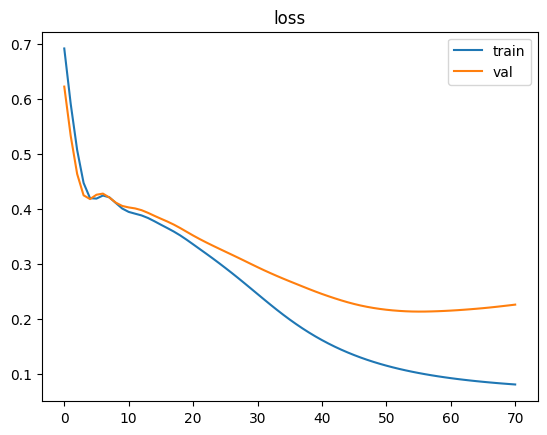

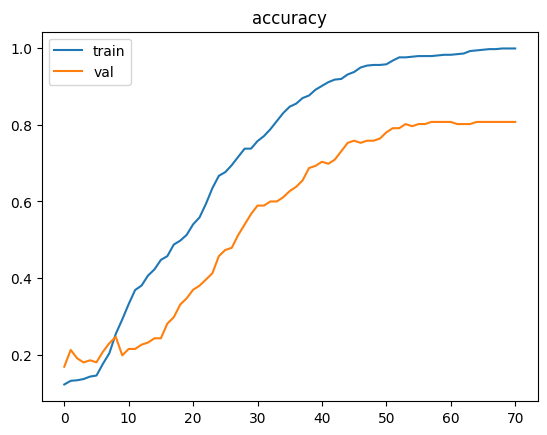

In [11]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [12]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.12772134623744272
train_accuracy: 0.9384615421295166
loss: 0.20405057885430075
accuracy: 0.8214285752990029


In [72]:
class LFCNN(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = nn.Linear(n_channels, n_latent, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x.permute(0, -1, 1))
        x = self.temp_conv(x.permute(0, -1, 1))
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 204, 301))

LFCNN(204, 301, 8, 50, 10, 8)(X)

/home/user/Projects/deepmeg/venv/lib/python3.11/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


tensor([[ 0.0277,  0.0317, -0.0253, -0.0031,  0.1022, -0.1843, -0.1350, -0.2432]],
       grad_fn=<AddmmBackward0>)

In [55]:
model = LFCNN(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7188   |    accuracy_train:  0.1348   |    loss_val:  0.6984   |    accuracy_val:  0.1645
Epoch 1:  loss_train:  0.6901   |    accuracy_train:  0.1740   |    loss_val:  0.6713   |    accuracy_val:  0.1812
Epoch 2:  loss_train:  0.6581   |    accuracy_train:  0.1935   |    loss_val:  0.6398   |    accuracy_val:  0.1978
Epoch 3:  loss_train:  0.6206   |    accuracy_train:  0.2408   |    loss_val:  0.6040   |    accuracy_val:  0.2367
Epoch 4:  loss_train:  0.5782   |    accuracy_train:  0.2859   |    loss_val:  0.5661   |    accuracy_val:  0.2860
Epoch 5:  loss_train:  0.5346   |    accuracy_train:  0.3296   |    loss_val:  0.5309   |    accuracy_val:  0.3082
Epoch 6:  loss_train:  0.4956   |    accuracy_train:  0.3415   |    loss_val:  0.5029   |    accuracy_val:  0.3357
Epoch 7:  loss_train:  0.4643   |    accuracy_train:  0.3821   |    loss_val:  0.4807   |    accuracy_val:  0.3516
Epoch 8:  loss_train:  0.4380   |    accuracy_train:  0.4129   |    loss_val:  0

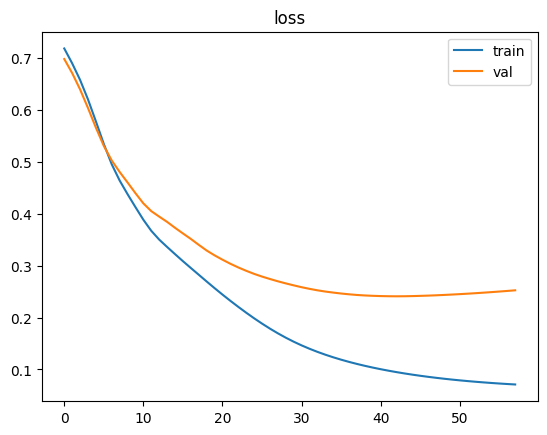

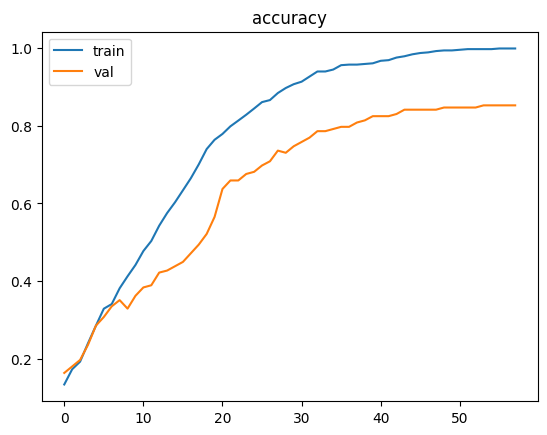

In [56]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [60]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.13186277990991419
train_accuracy: 0.9368881149725481
loss: 0.22104598581790924
accuracy: 0.8733766241507097


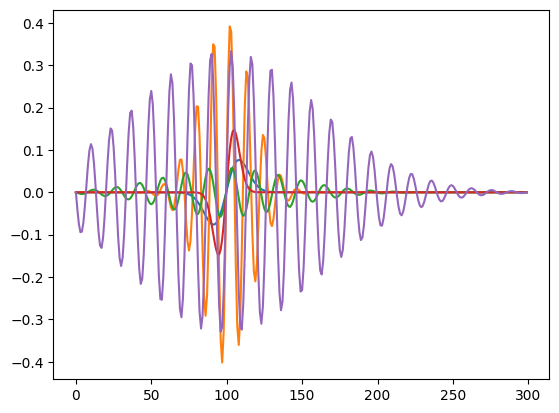

In [221]:
def get_wave(t, phi, A, f, s):
    return A*np.sin(2*np.pi*f*(t-phi)) * np.exp(-(t-phi)**2/s**2)

# x = np.arange(1000)
x = np.linspace(0, 1.5, 300)
y = -x**2 + 1
phi = .4
# y = np.sin(.1*(x-phi))*np.exp(-(x-phi)**2/10000)
n_samples = 200
y_rand = np.array([
    get_wave(x, .5, np.random.rand(), np.random.randint(1, 20), np.random.rand()/2) for _ in range(n_samples//2)
])
y_rand = np.concatenate((
    y_rand,
    np.array([
        get_wave(x, np.random.rand(), np.random.rand(), 50, np.random.rand()/2) for _ in range(n_samples//2)
    ])
))
plt.plot(y_rand[:5].T)
X = y_rand

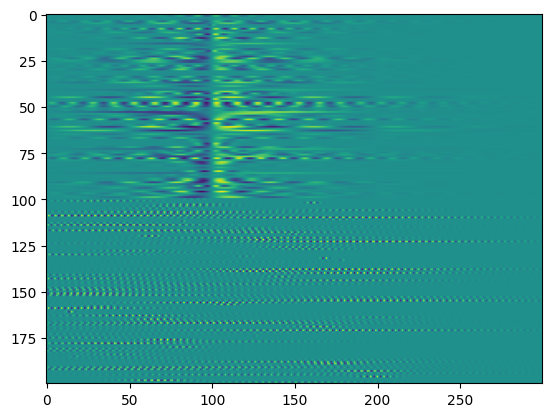

In [222]:
plt.imshow(X, aspect='auto')

(200, 15)


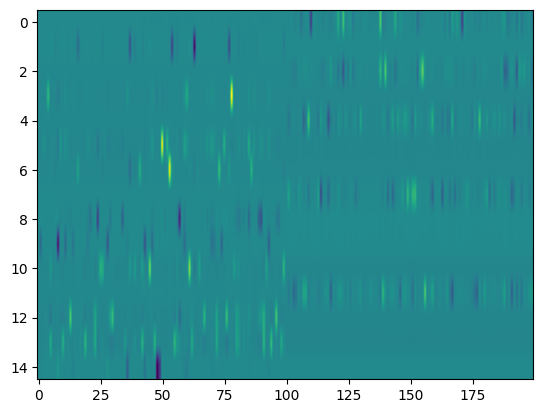

In [223]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=15, whiten='unit-variance')
X_transformed = transformer.fit_transform(X)
print(X_transformed.shape)
plt.imshow(X_transformed.T, aspect='auto')

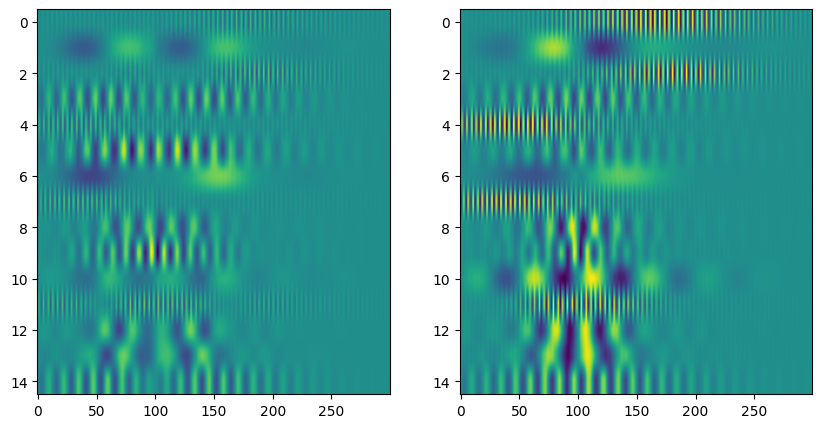

In [224]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(transformer.components_, aspect='auto')
ax2.imshow(transformer.mixing_.T, aspect='auto')

(300, 15)


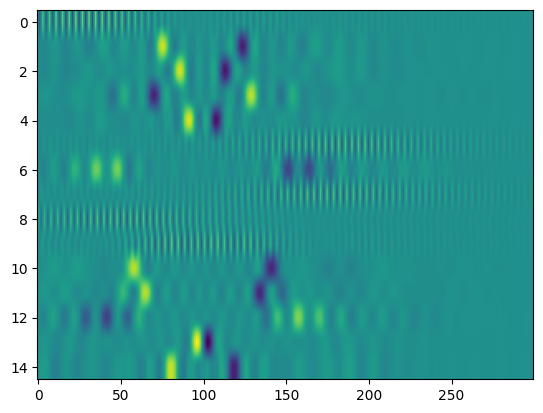

In [225]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=15, whiten='unit-variance')
X_transformed = transformer.fit_transform(X.T)
print(X_transformed.shape)
plt.imshow(X_transformed.T, aspect='auto')

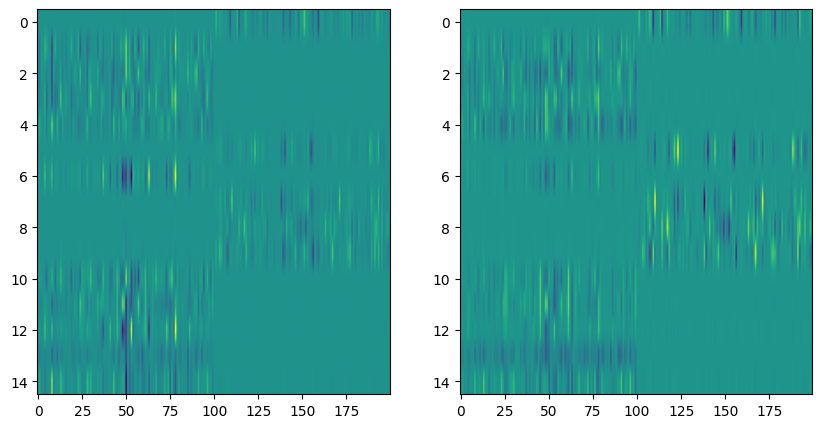

In [226]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(transformer.components_, aspect='auto')
ax2.imshow(transformer.mixing_.T, aspect='auto')

In [243]:
class STICA(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        n_compressed: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = nn.Linear(n_channels, n_latent, bias=True)
        self.compressing_layer = nn.Linear(n_times, n_compressed, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        n_temp_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        n_spatial_features = (n_channels//pool_factor)*n_compressed if not n_channels%pool_factor else (n_channels//pool_factor + 1)*n_compressed
        final_out_features = n_temp_features + n_spatial_features
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x_t = self.compressing_layer(x)
        x = self.unmixing_layer(x.permute(0, -1, 1))
        x = self.temp_conv(x.permute(0, -1, 1))
        x = x[:, :, ::self.pool_factor].contiguous()
        x_t = x_t[:, ::self.pool_factor, :].contiguous()
        x = torch.flatten(x, 1)
        x_t = torch.flatten(x_t, 1)
        x = torch.cat((x, x_t), dim=1)
        return self.fc_layer(x)

X = torch.rand((1, 204, 301))

STICA(204, 301, 8, 8, 50, 10, 8)(X)

tensor([[ 0.1279,  0.2091, -0.0389,  0.3253,  0.0657, -0.3306,  0.0337, -0.1538]],
       grad_fn=<AddmmBackward0>)

In [255]:
list(map(lambda x: x[0], model.named_parameters()))

['unmixing_layer.weight',
 'unmixing_layer.bias',
 'compressing_layer.weight',
 'compressing_layer.bias',
 'temp_conv.weight',
 'temp_conv.bias',
 'fc_layer.weight',
 'fc_layer.bias']

In [263]:
model = STICA(
    n_channels=x.shape[1],
    n_times=x.shape[-1],
    filter_size=50,
    n_latent=8,
    n_compressed=8,
    pool_factor=10,
    n_outputs=y.shape[-1]
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'compressing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7420   |    accuracy_train:  0.1305   |    loss_val:  0.7215   |    accuracy_val:  0.1701
Epoch 1:  loss_train:  0.7002   |    accuracy_train:  0.1933   |    loss_val:  0.6913   |    accuracy_val:  0.2364
Epoch 2:  loss_train:  0.6591   |    accuracy_train:  0.2821   |    loss_val:  0.6584   |    accuracy_val:  0.2638
Epoch 3:  loss_train:  0.6150   |    accuracy_train:  0.3519   |    loss_val:  0.6218   |    accuracy_val:  0.3079
Epoch 4:  loss_train:  0.5685   |    accuracy_train:  0.4197   |    loss_val:  0.5819   |    accuracy_val:  0.3079
Epoch 5:  loss_train:  0.5217   |    accuracy_train:  0.4992   |    loss_val:  0.5401   |    accuracy_val:  0.3134
Epoch 6:  loss_train:  0.4768   |    accuracy_train:  0.5765   |    loss_val:  0.5000   |    accuracy_val:  0.3468
Epoch 7:  loss_train:  0.4364   |    accuracy_train:  0.6510   |    loss_val:  0.4660   |    accuracy_val:  0.4228
Epoch 8:  loss_train:  0.4017   |    accuracy_train:  0.7023   |    loss_val:  0

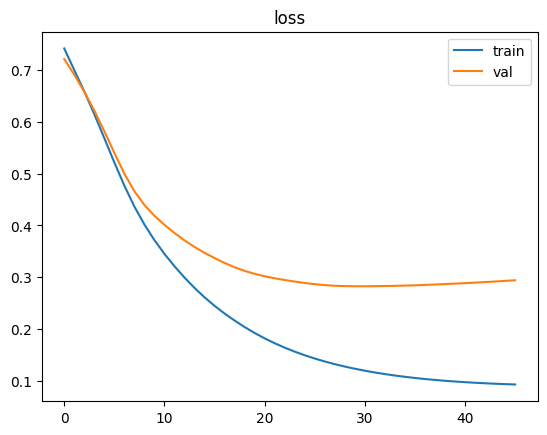

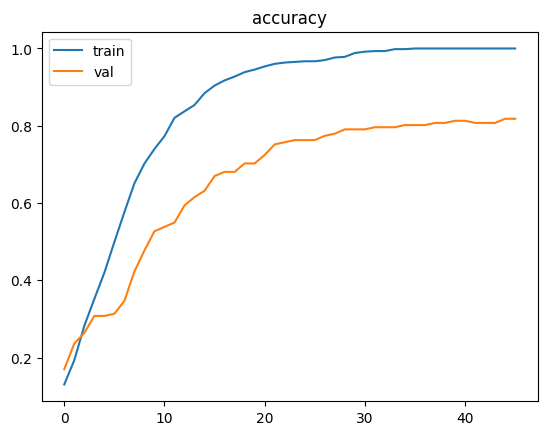

In [264]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [267]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.15279079431837256
train_accuracy: 0.9482517513361844
loss: 0.24284786663272165
accuracy: 0.8668831261721525


In [285]:
train_x, _ = next(iter(DataLoader(train, len(train))))

In [286]:
train_x.shape

torch.Size([658, 204, 301])

In [294]:
temp_patterns = model.compressing_layer.weight.detach().numpy()@np.cov(train_x.view(-1, 301).numpy().T)

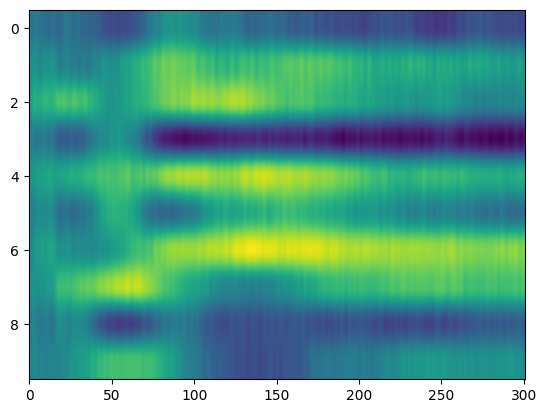

In [295]:
plt.imshow(temp_patterns, aspect='auto')

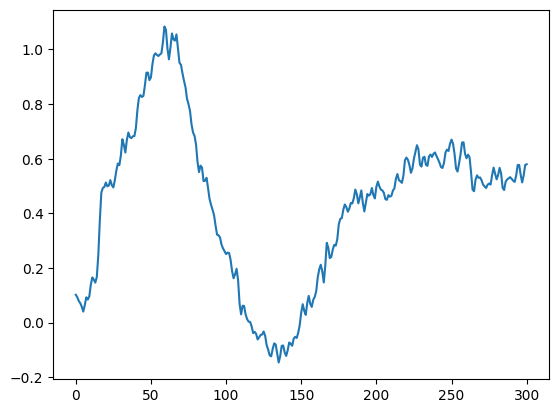

In [303]:
plt.plot(temp_patterns[7])

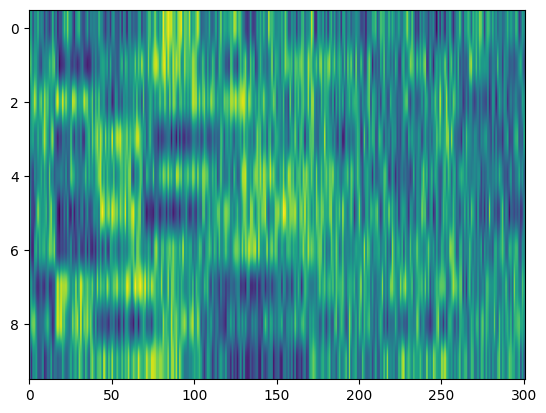

In [271]:
plt.imshow(model.compressing_layer.weight.detach().numpy(), aspect='auto')

In [3]:
class STICA(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        n_compressed: int,
        n_outputs: int
    ):
        super().__init__()
        self.n_latent = n_latent
        self.unmixing_layer = nn.Linear(n_channels, n_latent, bias=True)
        self.compressing_layer = nn.Linear(n_times, n_compressed, bias=True)
        final_out_features = n_latent*n_compressed
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x.permute(0, -1, 1))
        x = self.compressing_layer(x.permute(0, -1, 1))
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 204, 301))

STICA(204, 301, 8, 20, 8)(X)

tensor([[ 0.0345,  0.0847,  0.1932,  0.0509, -0.0447, -0.0702, -0.0200,  0.1898]],
       grad_fn=<AddmmBackward0>)

In [4]:
model = STICA(
    n_channels=x.shape[1],
    n_times=x.shape[-1],
    n_latent=8,
    n_compressed=8,
    n_outputs=y.shape[-1]
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'compressing_layer.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [6]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7311   |    accuracy_train:  0.1633   |    loss_val:  0.7213   |    accuracy_val:  0.1423
Epoch 1:  loss_train:  0.7100   |    accuracy_train:  0.1895   |    loss_val:  0.7029   |    accuracy_val:  0.1590
Epoch 2:  loss_train:  0.6872   |    accuracy_train:  0.2366   |    loss_val:  0.6808   |    accuracy_val:  0.1864
Epoch 3:  loss_train:  0.6598   |    accuracy_train:  0.2688   |    loss_val:  0.6540   |    accuracy_val:  0.2360
Epoch 4:  loss_train:  0.6272   |    accuracy_train:  0.2888   |    loss_val:  0.6229   |    accuracy_val:  0.2357
Epoch 5:  loss_train:  0.5902   |    accuracy_train:  0.3098   |    loss_val:  0.5892   |    accuracy_val:  0.2634
Epoch 6:  loss_train:  0.5509   |    accuracy_train:  0.3440   |    loss_val:  0.5555   |    accuracy_val:  0.2797
Epoch 7:  loss_train:  0.5123   |    accuracy_train:  0.3710   |    loss_val:  0.5247   |    accuracy_val:  0.2742
Epoch 8:  loss_train:  0.4771   |    accuracy_train:  0.3791   |    loss_val:  0

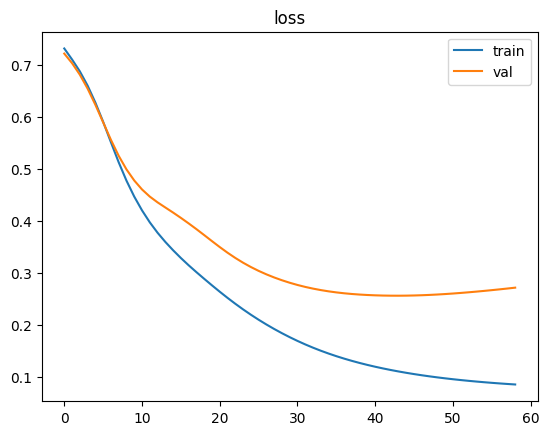

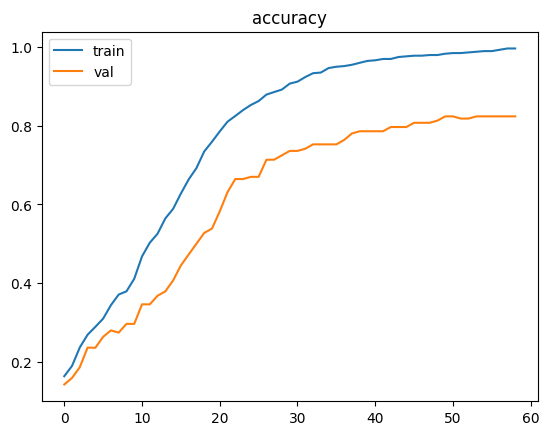

In [7]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [10]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.14009780910882083
train_accuracy: 0.9384615421295166
loss: 0.2562364624305205
accuracy: 0.8116883093660529
